In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.dist_math import *
import seaborn
seaborn.set_style('ticks')
seaborn.set_context('talk', font_scale=0.8)

In [2]:
#PyMC3 doesn't have an implementation of the hypergeometric function, so we'll just write one
class Hypergeometric(Discrete):
    """
    
    """
    def __init__(self, N, K, n, *args, **kwargs):
        super(Hypergeometric, self).__init__(*args, **kwargs)
        self.N = N
        self.K = K
        self.n = n
        self.mode = cast(floor((n + 1) * (K + 1) / (N + 2)), self.dtype)
        
    def logp(self, value):
        N = self.N
        K = self.K
        n = self.n
        
        return bound(
            
            factln(K) - factln(value) - factln(
                K - value) + factln(N - value) - factln(
                n - value) - factln(N + value - K - n) + factln(
                n) + factln(N - n) - factln(N),
            
            0 <= value, value <=n
            )


$$
    \begin{align}
        p_M &\sim \text{Uniform}(0,\, 1) & \text{Merger probability}\\
        N^S_{RQ,M} &\sim \text{Binomial}(N=N^S_{RQ},\, p=p_M) & \text{Number of RQ mergers in sample}\\
        K^T_{RL,M} &\sim \text{Binomial}(N=N^T_{RL},\, p=p_M) & \text{Number of RL mergers in population}\\
        N^S_{RL,M} &\sim \text{Hypergeometric}(n=N^S_{RL},\, N=N^T_{RL},\, K=K^T_{RL,M}) & \text{Number of RL mergers in sample}
    \end{align}
$$

In [3]:
N_T_RL = 58 #number of RL galaxies in population
N_S_RL = 12 #size of RL sample
N_S_RL_M = 12 #number of mergers in RL sample

N_S_RQ = 35 #size of RQ sample (LP + HP)
N_S_RQ_M = 13 #number of mergers in RQ in sample

In [4]:
with pm.Model() as null_model:
    p_M = pm.Uniform('$p_M$', lower=0, upper=1)
    RQ_obs = pm.Binomial('$N^S_{RQ,M}$', p=p_M, n=N_S_RQ, observed=N_S_RQ_M)
    
    K_T_RL_M = pm.Binomial('$K^T_{RL,M}$', p=p_M, n=N_T_RL)
    RL_obs = Hypergeometric('$N^S_{RL,M}$', N=N_T_RL, K=K_T_RL_M, n=N_S_RL, observed=N_S_RL_M)

In [5]:
with null_model:
    trace = pm.sample(10000, pm.Metropolis())

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

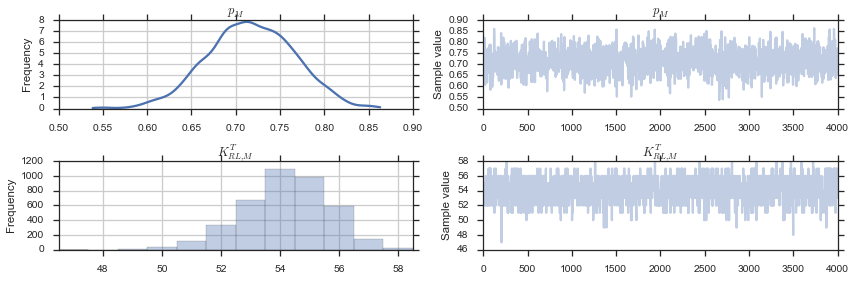

In [6]:
pm.traceplot(trace[2000::2], vars=['$p_M$', '$K^T_{RL,M}$']);

Try using $N^{rep}_{RL,M}$ as a test statistic. At fixed $K^P_{RL,M}$, the $p$-value is:
$$
    p(N^{rep}_{RL,M} \geq N^S_{RL,M} \vert K^T_{RL,M}) = p(N^{rep}_{RL,M} = N^S_{RL} \vert K^T_{RL,M}).
$$

The posterior predictive $p$-value is then 
$$
    \sum_{K^T_{RL,M}=0}^{N^T_{RL}} p(N^{rep}_{RL,M} = N^S_{RL} \vert K^T_{RL,M}) p(K^T_{RL,M})
    \approx \frac{1}{N_{draws}}\sum_{K^T_{RL,M} \text{ draws}} p(N^{rep}_{RL,M} = N^S_{RL} \vert K^T_{RL,M})
$$

In [7]:
from scipy.stats import hypergeom
K_T_RL_M_samples = trace.get_values('$K^T_{RL,M}$', burn=2000, thin=2)
p_value = [hypergeom.pmf(N_S_RL, N_T_RL, N_S_RL, K) for K in K_T_RL_M_samples]
p_value = np.average(p_value)
print p_value

0.428844385422


This $p$-value is quite high. What if we try a mixed predictive $p$-value instead? Generate a hypothetical population  given $p_M$ (but not the data), then ask what the probability of getting 12/12 RL mergers is. 

In [8]:
from scipy.stats import binom
K_T_RL_M_mixed_samples = binom.rvs(N_T_RL, trace.get_values('$p_M$', burn=2000, thin=2))
p_value = [hypergeom.pmf(N_S_RL, N_T_RL, N_S_RL, K) for K in K_T_RL_M_mixed_samples]
p_value = np.average(p_value)
print p_value

0.0254081086663


Low, though higher than the 1% threshold. The mixed predictive $p$-value is an order of magnitude lower than the posterior predictive $p$-value because the sort of $K^T_{RL,M}$ needed to make getting 12/12 RL mergers likely conflicts rather strongly with the prior on $K^T_{RL,M}$. If we remove the \emph{direct} influence of the likelihood on $K^T_{RL,M}$, leaving only its slightly diluted influence on $p_M$, we find that the sort of RL population we would need to frequently get the observed sample is fairly unlikely.